In [345]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import DBSCAN
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
import copy
from collections import Counter
from sklearn.metrics import accuracy_score, roc_auc_score
import os
import pickle
from catboost import CatBoostClassifier, Pool
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import timedelta


In [346]:
clients_promo_october = pd.read_csv("/kaggle/input/cleancodus/clients_promo_october.csv")
mobile_events = pd.read_csv("/kaggle/input/cleancodus/mobile_events.csv")
orders = pd.read_csv("/kaggle/input/cleancodus/orders.csv")
test = pd.read_csv("/kaggle/input/cleancodus/test.csv")
train = pd.read_csv("/kaggle/input/cleancodus/train_target.csv")

# count from october

In [347]:
# MAKE COUNT FROM OCTOBER

# Convert Timestamp, LocalBeginDate and LocalEndDate to datetime format
mobile_events['Timestamp'] = pd.to_datetime(mobile_events['Timestamp'])
clients_promo_october['LocalBeginDate'] = pd.to_datetime(clients_promo_october['LocalBeginDate'])
clients_promo_october['LocalEndDate'] = pd.to_datetime(clients_promo_october['LocalEndDate'])

# Merge the two dataframes on ClientUUId
merged_df = pd.merge(mobile_events, clients_promo_october, on='ClientUUId')

# Filter rows where EventName is either 'apply_personal_offer' or 'create_order'
filtered_df = merged_df[merged_df['EventName'].isin(['apply_personal_offer', 'create_order'])]

# Sort the dataframe by ClientUUId and Timestamp
filtered_df = filtered_df.sort_values(['ClientUUId', 'Timestamp'])
filtered_df = filtered_df[(filtered_df['Timestamp'] > filtered_df['LocalBeginDate'] )&(filtered_df['LocalEndDate'] > filtered_df['Timestamp'] )]
filtered_df.drop_duplicates(subset = ['ClientUUId','EventName','Timestamp'], inplace = True)


results = {}

# Group by ClientUUId and iterate over each group
for client_id, group in tqdm(filtered_df.groupby('ClientUUId')):
    count_orders = group[group['EventName'] == 'create_order'].shape[0]
    count_orders_with_promo = 0

    # Iterate over the rows of the group
    for i in range(len(group) - 1):
        row1 = group.iloc[i]
        row2 = group.iloc[i + 1]

        # Check if the EventNames are 'apply_personal_offer' and 'create_order' in that order
        if row1['EventName'] == 'apply_personal_offer' and row2['EventName'] == 'create_order':
            # Check if the time difference is less than or equal to 1 hour
            if (row2['Timestamp'] - row1['Timestamp']) <= timedelta(hours=1):
                count_orders_with_promo += 1

    results[client_id] = (count_orders, count_orders_with_promo)

# Convert the results dictionary to a dataframe
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['count_orders', 'count_orders_with_promo'])

# Reset the index of the results dataframe
results_df.reset_index(inplace=True)

# Rename the index column to 'ClientUUId'
results_df.rename(columns={'index': 'ClientUUId'}, inplace=True)

# Merge the results dataframe with the clients_promo_october dataframe
final_df = pd.merge(clients_promo_october, results_df, on='ClientUUId', how='left')

# Fill NaN values with 0
final_df.fillna(0, inplace=True)

# Convert the new columns to integers
final_df['count_orders'] = final_df['count_orders'].astype(int)
final_df['count_orders_with_promo'] = final_df['count_orders_with_promo'].astype(int)

# Convert the results dictionary to a dataframe
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['count_orders', 'count_orders_with_promo'])

# Reset the index of the results dataframe
results_df.reset_index(inplace=True)

# Rename the index column to 'ClientUUId'
results_df.rename(columns={'index': 'ClientUUId'}, inplace=True)

# Merge the results dataframe with the clients_promo_october dataframe
final_df = pd.merge(clients_promo_october, results_df, on='ClientUUId', how='left')

# Fill NaN values with 0
final_df.fillna(0, inplace=True)

# Convert the new columns to integers
final_df['count_orders'] = final_df['count_orders'].astype(int)
final_df['count_orders_with_promo'] = final_df['count_orders_with_promo'].astype(int)

cpo = clients_promo_october.groupby('ClientUUId').count()
cpo['all_promo_october'] = cpo['Id']
cpo.reset_index(inplace = True)
final_df = pd.merge(final_df,cpo[['ClientUUId','all_promo_october']], on = "ClientUUId")

100%|██████████| 28789/28789 [00:36<00:00, 778.89it/s]


In [348]:
a = np.unique(mobile_events['ClientUUId'])
b = np.unique(orders['ClientUUId'])
c = np.unique(clients_promo_october['ClientUUId'])
d = np.unique(train['ClientUUId'])
e = np.unique(test['ClientUUId'])

In [349]:
mobile_events['Platform'] = mobile_events['Platform'].apply(lambda x: 1 if x == 'ios' else 0)

In [350]:
clients_promo_october['Id_5'] = (clients_promo_october['Id'] == 5).astype(int)
clients_promo_october['Id_6'] = (clients_promo_october['Id'] == 6).astype(int)
clients_promo_october['Id_7'] = (clients_promo_october['Id'] == 7).astype(int)

cpo_ids = clients_promo_october.groupby('ClientUUId').agg(
    id_7_count_prev_month = ('Id_7','sum'),
    id_6_count_prev_month = ('Id_6','sum'),
    id_5_count_prev_month = ('Id_5','sum'),
)

In [351]:
orders['dif_price'] = orders['MenuPrice']-orders['ProductTotalPrice']

In [352]:
def get_mode(x):
    r = x.mode()
    if type(r) != int: return r[0]
    return r

In [353]:
orders['Date'] = pd.to_datetime(orders['Date'])

In [354]:
train1 = pd.merge(train,final_df[['ClientUUId','count_orders','count_orders_with_promo','all_promo_october']].drop_duplicates(subset = 'ClientUUId'), on = 'ClientUUId', how = 'left')
train1 = pd.merge(train1, mobile_events[['ClientUUId','Platform']].groupby('ClientUUId').mean().reset_index(), on = 'ClientUUId', how = 'left')
train1['Platform'] = train1['Platform'].astype(float)
train1 = pd.merge(train1, cpo_ids.reset_index()[['ClientUUId','id_7_count_prev_month','id_6_count_prev_month','id_5_count_prev_month']], on = 'ClientUUId', how = 'left')
train1['Id'] = train1['Id'].astype('object')
train1.fillna(0, inplace = True)
train1 = pd.merge(train1,mobile_events.groupby('ClientUUId')['EventName'].value_counts().unstack(fill_value=0).reset_index(), how = 'left')
for i in list(train1):
    train1[i] = train1[i].fillna(0)
for i in range(3,11):
    agg1 = orders[(orders['Date'] < pd.to_datetime(f'2023-{i+1}-01'))&(orders['Date'] >= pd.to_datetime(f'2023-{i}-01'))].groupby('ClientUUId').agg(
        {
            "OrderType": [get_mode, 'nunique'],
            "OrderPaymentType": [get_mode, 'nunique'],
            "ClientOrderNumber": ['max'],
            "CategoryId": [get_mode, 'nunique'],
            "ProductTotalPrice": ['mean','std','median'],
            "MenuPrice": ['mean','std','median'],
            "dif_price": ['mean','std','median']
        }
    )
    # Flatten the multi-index and create new column names
    agg1.columns = [f'{col[0]}_{col[1]}_{i}' for col in agg1.columns.values]
    train1 = pd.merge(train1,agg1,on = 'ClientUUId', how = 'left')
for i in list(train1):
    if 'mode' in i:
        train1[i] = train1[i].fillna(train1[i].mode()[0])
    else:
        train1[i] = train1[i].fillna(0)
for i in range(3,11):
    ids = set(orders[(orders['Date'] < pd.to_datetime(f'2023-{i+1}-01'))&(orders['Date'] >= pd.to_datetime(f'2023-{i}-01'))]['ClientUUId'])
    train1[f'ordered_in_{i}'] = train1['ClientUUId'].apply(lambda x: 1 if x in ids else 0)


/tmp/ipykernel_33/2983398418.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train1[i] = train1[i].fillna(0)
/tmp/ipykernel_33/2983398418.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train1[f'ordered_in_{i}'] = train1['ClientUUId'].apply(lambda x: 1 if x in ids else 0)
/tmp/ipykernel_33/2983398418.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-

In [355]:
unique_units = orders.groupby('ClientUUId')['UnitUUId'].nunique()
train1 = pd.merge(train1, unique_units, on = 'ClientUUId',how = 'left')
train1['UnitUUId'].fillna(0, inplace = True)

/tmp/ipykernel_33/1601979023.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train1['UnitUUId'].fillna(0, inplace = True)


In [356]:
unique_units = orders.groupby('ClientUUId')['ProductUUId'].nunique()
train1 = pd.merge(train1, unique_units, on = 'ClientUUId',how = 'left')
train1['ProductUUId'].fillna(0, inplace = True)

/tmp/ipykernel_33/3096079635.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train1['ProductUUId'].fillna(0, inplace = True)


In [ ]:
i have 2 dataframes that have same key ClientUUId, OrderType from the first should be substring of OrderType of the second, you must make column that represents how much unique OrderUUId of each ClientUUId has OrderPrice higher than OrderTotalPrice and SaleDate must be between LocalBeginDate and LocalEndDate, use groupby instead of iterations if it is possible to speed up the procces.

In [370]:
new_train1 = train1[['ClientUUId','OrderType','LocalBeginDate','LocalEndDate','OrderPrice']]

In [371]:

unique_units = orders.groupby('ClientUUId')['UnitUUId'].nunique()
unique_products = orders.groupby('ClientUUId')['ProductUUId'].nunique()
cpo1 = clients_promo_october[['ClientUUId','OrderType','LocalBeginDate','LocalEndDate','OrderPrice','Discount']]
unique_sales_orders = orders.drop_duplicates(subset = ['ClientUUId','OrderUUId'])[['ClientUUId','OrderTotalPrice','OrderType','SaleDate','OrderUUId','apply_promo']]
cpo1['OrderType'] = cpo1['OrderType'].astype(str)
unique_sales_orders['OrderType'] = unique_sales_orders['OrderType'].astype(str)
merged = pd.merge(cpo1, unique_sales_orders, on='ClientUUId', how = 'left')
merged['OrderType_x'] = merged['OrderType_x'].astype('str')
merged['OrderType_y'] = merged['OrderType_y'].astype('str')
merged['OrderType_match'] = merged.apply(lambda row: row['OrderType_y'] in row['OrderType_x'], axis=1)
merged = merged[merged['OrderType_match']]
merged['SaleDate'] = pd.to_datetime(merged['SaleDate'])
merged['LocalBeginDate'] = pd.to_datetime(merged['LocalBeginDate'])
merged['LocalEndDate'] = pd.to_datetime(merged['LocalEndDate'])
merged['SaleDate_in_range'] = merged.apply(lambda row: row['LocalBeginDate'] <= row['SaleDate'] <= row['LocalEndDate'], axis=1)
merged = merged[merged['SaleDate_in_range']]
merged['not_used_but_was_able'] = merged.apply(lambda x: (x['OrderTotalPrice'] >  x['OrderPrice']) & (x['apply_promo'] == 0), axis = 1).astype(int)
merged['diff_total_order'] =  merged.apply(lambda x: x['OrderTotalPrice'] - x['OrderPrice'], axis = 1)
merg = merged.groupby('ClientUUId').agg(
    {
        'diff_total_order': ['mean','std','median'],
        'not_used_but_was_able':['max','nunique']
    }
)
merg.columns = ['_'.join(col).strip() for col in merg.columns.values]

/tmp/ipykernel_33/2561000961.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpo1['OrderType'] = cpo1['OrderType'].astype(str)


In [372]:
X = train1.drop(['apply_promo','ClientUUId','LocalBeginDate','LocalEndDate'], axis = 1)
y = train1['apply_promo']

In [373]:
cat_cols = list(X.select_dtypes('object'))
num_cols = list(set(list(X)) - set(cat_cols))


# Кат фичи преведем в тип 'category'
for col in cat_cols:
    try:
        X[col] = X[col].astype('str')
    except:
        ...

In [374]:
good_features = ['count_orders_with_promo', 'Platform', 'id_7_count_prev_month', 'id_5_count_prev_month', 'add_to_cart', 'apply_personal_offer', 'close_app', 'create_order', 'open_app', 'open_bonusaction', 'open_product_card', 'remove_from_cart', 'screen_cart', 'screen_menu', 'screen_profile', 'ProductTotalPrice_mean_3', 'ProductTotalPrice_std_3', 'ProductTotalPrice_mean_4', 'ProductTotalPrice_mean_5', 'MenuPrice_mean_5', 'dif_price_mean_5', 'dif_price_std_5', 'CategoryId_nunique_6', 'ProductTotalPrice_mean_6', 'MenuPrice_mean_6', 'OrderPaymentType_get_mode_7', 'ProductTotalPrice_mean_7', 'MenuPrice_mean_7', 'MenuPrice_std_7', 'ProductTotalPrice_std_8', 'MenuPrice_mean_8', 'dif_price_std_8', 'OrderType_get_mode_9', 'OrderPaymentType_get_mode_9', 'ClientOrderNumber_max_9', 'CategoryId_get_mode_9', 'CategoryId_nunique_9', 'ProductTotalPrice_mean_9', 'ProductTotalPrice_std_9', 'MenuPrice_mean_9', 'dif_price_std_9', 'OrderType_get_mode_10', 'ClientOrderNumber_max_10', 'CategoryId_get_mode_10', 'CategoryId_nunique_10', 'ProductTotalPrice_mean_10', 'ProductTotalPrice_std_10', 'MenuPrice_mean_10', 'MenuPrice_std_10', 'dif_price_std_10', 'count_orders']
# good_features += ['UnitUUId']

In [375]:
# params = {'learning_rate': 0.04841227134550481, 'l2_leaf_reg': 14, 'colsample_bylevel': 0.7698884615915536, 'auto_class_weights': 'Balanced', 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6755767311059424}


cv = 3
skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=7575)
results = []
all_models = {}
all_predictions = {}

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    X_train = X_train[good_features]
    X_val = X_val[good_features]
    cat_cols1 = [x for x in cat_cols if x in good_features]
    models = {
        'catboost': ''
    }  
    
    fold_models = {}
    fold_predictions = {}
    for name, _ in models.items():
        try:
#                 print('#'*40)
#                 print(name)

            if name == 'catboost':
                # Специальный класс для ускорения обучения 
                train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_cols1)
                eval_dataset = Pool(data=X_val, label=y_val, cat_features=cat_cols1)

                model = CatBoostClassifier(
#                     **params,
                    depth=5,
                    iterations=1000,
                    learning_rate=0.05,
#                     eval_metric = 'F1',  # F1:macro / AUC:hints=skip_train~false
                    eval_metric='AUC:hints=skip_train~false',  # 'AUC / Accuracy,

                    # Главная фишка катбуста - работа с категориальными признаками
                    cat_features=cat_cols1,
                    # ignored_features = ignored_features,

#                     # Регуляризация и ускорение
#                     colsample_bylevel=0.098,
#                     subsample=0.95,
#                     l2_leaf_reg=9,
#                     min_data_in_leaf=243,
#                     max_bin=187,
#                     random_strength=1,

                    # Важное!
                    random_seed=7575,
#                     auto_class_weights="SqrtBalanced",
                    early_stopping_rounds=100)


                model.fit(
                        train_dataset,
                        eval_set=eval_dataset,
                        verbose=50,
                        use_best_model=True,
                        plot=False)
                y_pred_proba = model.predict_proba(eval_dataset)[:,1].flatten()


            acc = roc_auc_score(y_val,y_pred_proba)
            print(f"Fold {fold+1}/{cv} {name} roc auc = {acc}")

            fold_models[name] = model
            fold_predictions[name] = y_pred_proba
            results.append({'Fold': fold+1, 'Model': name, 'metric': acc})
        except Exception as e:
            print(f"Error training model {name} in fold {fold+1}: {e}")
            continue  

    all_models[fold] = fold_models
    all_predictions[fold] = fold_predictions
#     check_features[X.shape[1]] = sum([x['metric'] for x in results])/3



0:	learn: 0.6138369	test: 0.6179397	best: 0.6179397 (0)	total: 10ms	remaining: 10s
50:	learn: 0.7910143	test: 0.7596097	best: 0.7596097 (50)	total: 537ms	remaining: 9.99s
100:	learn: 0.8212000	test: 0.7776912	best: 0.7777315 (99)	total: 1.04s	remaining: 9.3s
150:	learn: 0.8429201	test: 0.7904067	best: 0.7905794 (148)	total: 1.56s	remaining: 8.76s
200:	learn: 0.8575084	test: 0.7994245	best: 0.7994245 (200)	total: 2.07s	remaining: 8.23s
250:	learn: 0.8721764	test: 0.8057610	best: 0.8057610 (250)	total: 2.58s	remaining: 7.71s
300:	learn: 0.8881716	test: 0.8145507	best: 0.8145507 (300)	total: 3.08s	remaining: 7.17s
350:	learn: 0.9000112	test: 0.8205881	best: 0.8205881 (350)	total: 3.59s	remaining: 6.64s
400:	learn: 0.9110339	test: 0.8262315	best: 0.8262315 (400)	total: 4.1s	remaining: 6.13s
450:	learn: 0.9199909	test: 0.8318810	best: 0.8318810 (450)	total: 4.67s	remaining: 5.68s
500:	learn: 0.9283257	test: 0.8377619	best: 0.8378292 (498)	total: 5.18s	remaining: 5.16s
550:	learn: 0.9343100	

In [ ]:
predict/=counter

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)


In [ ]:
model = CatBoostClassifier(
                    **params,
                    depth=5,
                    iterations=1000,
#                     learning_rate=0.05,
#                     eval_metric = 'F1',  # F1:macro / AUC:hints=skip_train~false
                    eval_metric='AUC:hints=skip_train~false',  # 'AUC / Accuracy,

                    # Главная фишка катбуста - работа с категориальными признаками
                    cat_features=cat_cols,
                    # ignored_features = ignored_features,

#                     # Регуляризация и ускорение
#                     colsample_bylevel=0.098,
#                     subsample=0.95,
#                     l2_leaf_reg=9,
#                     min_data_in_leaf=243,
#                     max_bin=187,
#                     random_strength=1,

                    # Важное!
                    random_seed=7575,
#                     auto_class_weights="SqrtBalanced",
                    early_stopping_rounds=100)

In [ ]:
summary = model.select_features(X_train, y_train, 
                      eval_set=(X_test, y_test),
                      features_for_select='0-93',
                      num_features_to_select=62,
                      steps=1,
                      train_final_model=False,
                      logging_level='Silent')

In [ ]:
d = pd.DataFrame({})

for _ in range(3):
    fi = all_models[_]['catboost'].get_feature_importance(prettified=True)
    for __ in list(fi):
        d[f"{__}_fold_{_}"] = fi[__]

In [ ]:
# sns.lineplot(y = list(check_features.values()), x = list(check_features.keys()))

In [376]:
test1 = pd.merge(test,final_df[['ClientUUId','count_orders','count_orders_with_promo','all_promo_october']].drop_duplicates(subset = 'ClientUUId'), on = 'ClientUUId',how = 'left')
test1 = pd.merge(test1, mobile_events[['ClientUUId','Platform']].groupby('ClientUUId').mean().reset_index(), on = 'ClientUUId',how = 'left')
test1['Platform'] = test1['Platform'].astype(float)
test1 = pd.merge(test1, cpo_ids.reset_index()[['ClientUUId','id_7_count_prev_month','id_6_count_prev_month','id_5_count_prev_month']], on = 'ClientUUId',how = 'left')
test1['Id'] = test1['Id'].astype('object')
test1 = pd.merge(test1,mobile_events.groupby('ClientUUId')['EventName'].value_counts().unstack(fill_value=0).reset_index(), how = 'left')
for i in list(test1):
    test1[i].fillna(0, inplace = True)
for i in range(3,11):
    agg1 = orders[(orders['Date'] < pd.to_datetime(f'2023-{i+1}-01'))&(orders['Date'] >= pd.to_datetime(f'2023-{i}-01'))].groupby('ClientUUId').agg(
        {
            "OrderType": [get_mode, 'nunique'],
            "OrderPaymentType": [get_mode, 'nunique'],
            "ClientOrderNumber": ['max'],
            "CategoryId": [get_mode, 'nunique'],
            "ProductTotalPrice": ['mean','std'],
            "MenuPrice": ['mean','std'],
            "dif_price": ['mean','std']
        }
    )
    # Flatten the multi-index and create new column names
    agg1.columns = [f'{col[0]}_{col[1]}_{i}' for col in agg1.columns.values]
    test1 = pd.merge(test1,agg1,on = 'ClientUUId', how = 'left')
for i in list(test1):
    if 'mode' in i:
        test1[i] = test1[i].fillna(test1[i].mode())
    else:
        test1[i] = test1[i].fillna(0)
for i in range(3,11):
    ids = set(orders[(orders['Date'] < pd.to_datetime(f'2023-{i+1}-01'))&(orders['Date'] >= pd.to_datetime(f'2023-{i}-01'))]['ClientUUId'])
    test1[f'ordered_in_{i}'] = test1['ClientUUId'].apply(lambda x: 1 if x in ids else 0)


/tmp/ipykernel_33/939955939.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test1[i].fillna(0, inplace = True)
/tmp/ipykernel_33/939955939.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test1[i] = test1[i].fillna(0)
/tmp/ipykernel_33/939955939.py:31: PerformanceWarning: DataFrame is highly fragmented.

In [377]:
test1['Platform'] = test1['Platform'].fillna(0)

In [378]:
# for i in range(3,11):
#     ids = set(orders[(orders['Date'] < pd.to_datetime(f'2023-{i+1}-01'))&(orders['Date'] >= pd.to_datetime(f'2023-{i}-01'))]['ClientUUId'])
#     test1[f'ordered_in_{i}'] = test1['ClientUUId'].apply(lambda x: 1 if x in ids else 0)


In [379]:
predict = np.array([0.0 for _ in range(test1.shape[0])])
for i in range(3):
    for mod in all_models[i].keys():
        predict += all_models[i][mod].predict_proba(test1[all_models[i][mod].feature_names_])[:,1]
predict/=3



In [380]:
# predict = model.predict_proba(test1[model.feature_names_])[:,1]

In [381]:
submit = pd.read_csv('/kaggle/input/cleancodus/test.csv')

In [382]:
test1['predict'] = predict

/tmp/ipykernel_33/137463022.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test1['predict'] = predict


In [383]:
submit['apply_promo'] = submit.apply(lambda x: test1[test1['ClientUUId'] == x['ClientUUId']]['predict'].iloc[0], axis = 1)

In [384]:
submit.fillna(0, inplace = True)

<Axes: ylabel='Density'>

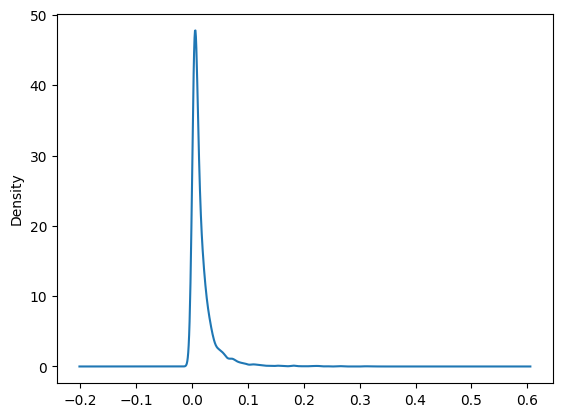

In [387]:
submit['apply_promo'].plot.kde()

In [386]:
submit.to_csv("submit9_test.csv", index = False)